<a href="https://colab.research.google.com/github/linhmai19/telecom_customer_attrition_analysis/blob/master/customer_churn_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Analysis Project

* Student name: Linh Mai
* Student pace: self paced
* Scheduled project review date/time: July 13th, 2020 
* Instructor name: Jeff Herman
* Blog post URL: https://linhmai19.github.io/ 


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cleaned_customer_churn.csv to cleaned_customer_churn.csv


# Column Description 

Below is the description for each of the columns in the cleaned dataset

* state: the state the user lives in
* account length: the number of days the user has this account
* international plan: true if the user has the international plan, otherwise false
* voice mail plan: true if the user has the voice mail plan, otherwise false
* number vmail messages: the number of voice mail messages the user has sent
* total day minutes: total number of minutes the user has been in calls during the day
* total day calls: total number of calls the user has done during the day
* total day charge: total amount of money the user was charged by the Telecom company for calls during the day
* total eve minutes: total number of minutes the user has been in calls during the evening
* total eve calls: total number of calls the user has done during the evening
* total eve charge: total amount of money the user was charged by the Telecom company for calls during the evening
* total night minutes: total number of minutes the user has been in calls during the night
* total night calls: total number of calls the user has done during the night
* total night charge: total amount of money the user was charged by the Telecom company for calls during the night
* total intl minutes: total number of minutes the user has been in international calls
* total intl calls: total number of international calls the user has done
* total intl charge: total amount of money the user was charged by the Telecom company for international calls
* customer service calls: number of customer service calls the user has done
* churn: true if the user terminated the contract, otherwise false
* total charge: total amount of money the user was charged by the Telecom company overall

# Import libraries

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import itertools  
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures

from imblearn.pipeline import make_pipeline, Pipeline

# Import the cleaned dataset and review it

In [ ]:
df = pd.read_csv('cleaned_customer_churn.csv')
df = df.drop('Unnamed: 0', 1)
df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,total charge
0,KS,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,75.56
1,OH,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,59.24
2,NJ,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,62.29
3,OH,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False,66.80
4,OK,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False,52.09


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3260 entries, 0 to 3259
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3260 non-null   object 
 1   account length          3260 non-null   int64  
 2   international plan      3260 non-null   object 
 3   voice mail plan         3260 non-null   object 
 4   number vmail messages   3260 non-null   int64  
 5   total day minutes       3260 non-null   float64
 6   total day calls         3260 non-null   int64  
 7   total day charge        3260 non-null   float64
 8   total eve minutes       3260 non-null   float64
 9   total eve calls         3260 non-null   int64  
 10  total eve charge        3260 non-null   float64
 11  total night minutes     3260 non-null   float64
 12  total night calls       3260 non-null   int64  
 13  total night charge      3260 non-null   float64
 14  total intl minutes      3260 non-null   

## Visualize the distribution of the target variable

In [ ]:
df['churn'].value_counts(normalize=True)

False    0.856135
True     0.143865
Name: churn, dtype: float64

False    2791
True      469
Name: churn, dtype: int64


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

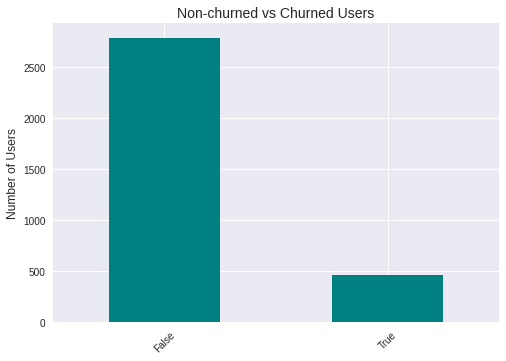

In [ ]:
print(df.churn.value_counts())
df['churn'].value_counts().plot(kind='bar', color='teal')
plt.title('Non-churned vs Churned Users', fontsize=14)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=45)

# Deal with Categorical features

### Visualize Categorical features

In [ ]:
# Categorical features
cat_feats = ['state', 'international plan', 'voice mail plan']

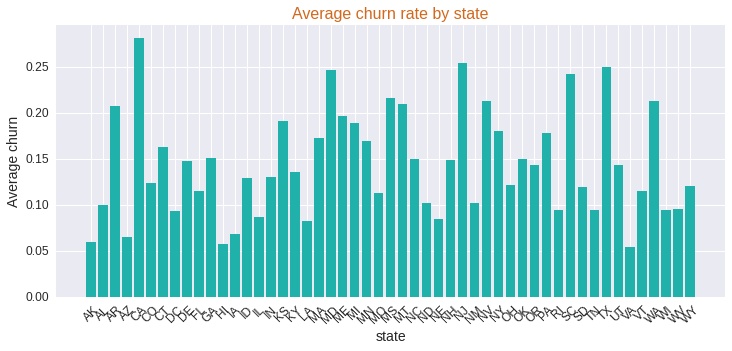

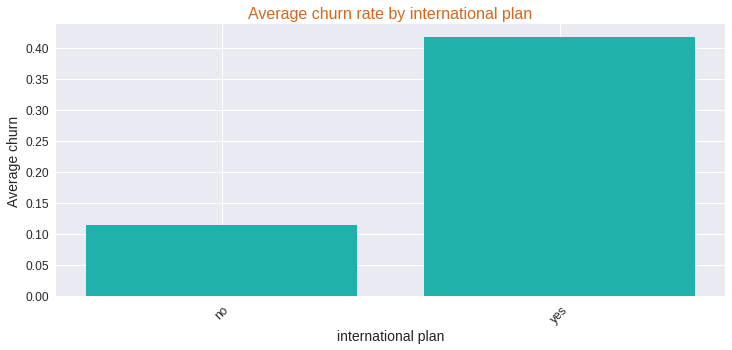

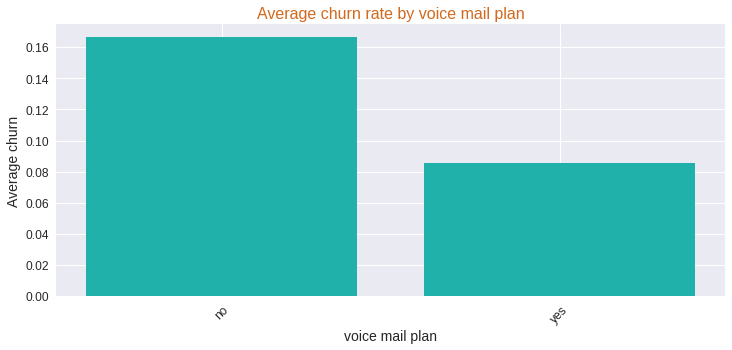

In [ ]:
def visualize_influence(feature_list):
    for feature in feature_list:
        df_plot = df.groupby([feature])['churn'].mean().reset_index()
        x = df_plot[feature]
        y = df_plot['churn']
        plt.figure(figsize=(12, 5))
        plt.bar(x, y, color='lightseagreen')
        plt.xlabel(feature, fontsize=14)
        plt.ylabel('Average churn', fontsize=14)
        plt.title(f'Average churn rate by {feature}', fontsize=16, color='chocolate')
        plt.xticks(fontsize=12, rotation=45)
        plt.yticks(fontsize=12)
        plt.show();
        
visualize_influence(cat_feats)

#### General comments on the visualization 
* The states with high amount of churned customers are CA, MD, NU, SC, and TX
* The states with low amount of churned customers are AK, AZ, HI, and VA
* Customers with the international plan have higher proportion of churn than the customers without
* Nothing special to comment more on the plot for churn rate by voice mail plan

### LabelEncoding Categorical features

In [ ]:
# LabelEncoding the categorical features into numeric values
label_encode = LabelEncoder()

df['state'] = label_encode.fit_transform(df['state'])
df['international plan'] = label_encode.fit_transform(df['international plan'])
df['voice mail plan'] = label_encode.fit_transform(df['voice mail plan'])

# Deal with Continuous features

### Visualize Continuous features

In [ ]:
# Continuous features
con_feats = ['account length', 'number vmail messages', 'total day minutes', 'total day calls', 
             'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge',
             'total night minutes', 'total night calls', 'total night charge', 'total intl minutes',
             'total intl calls', 'total intl charge', 'customer service calls', 'total charge']

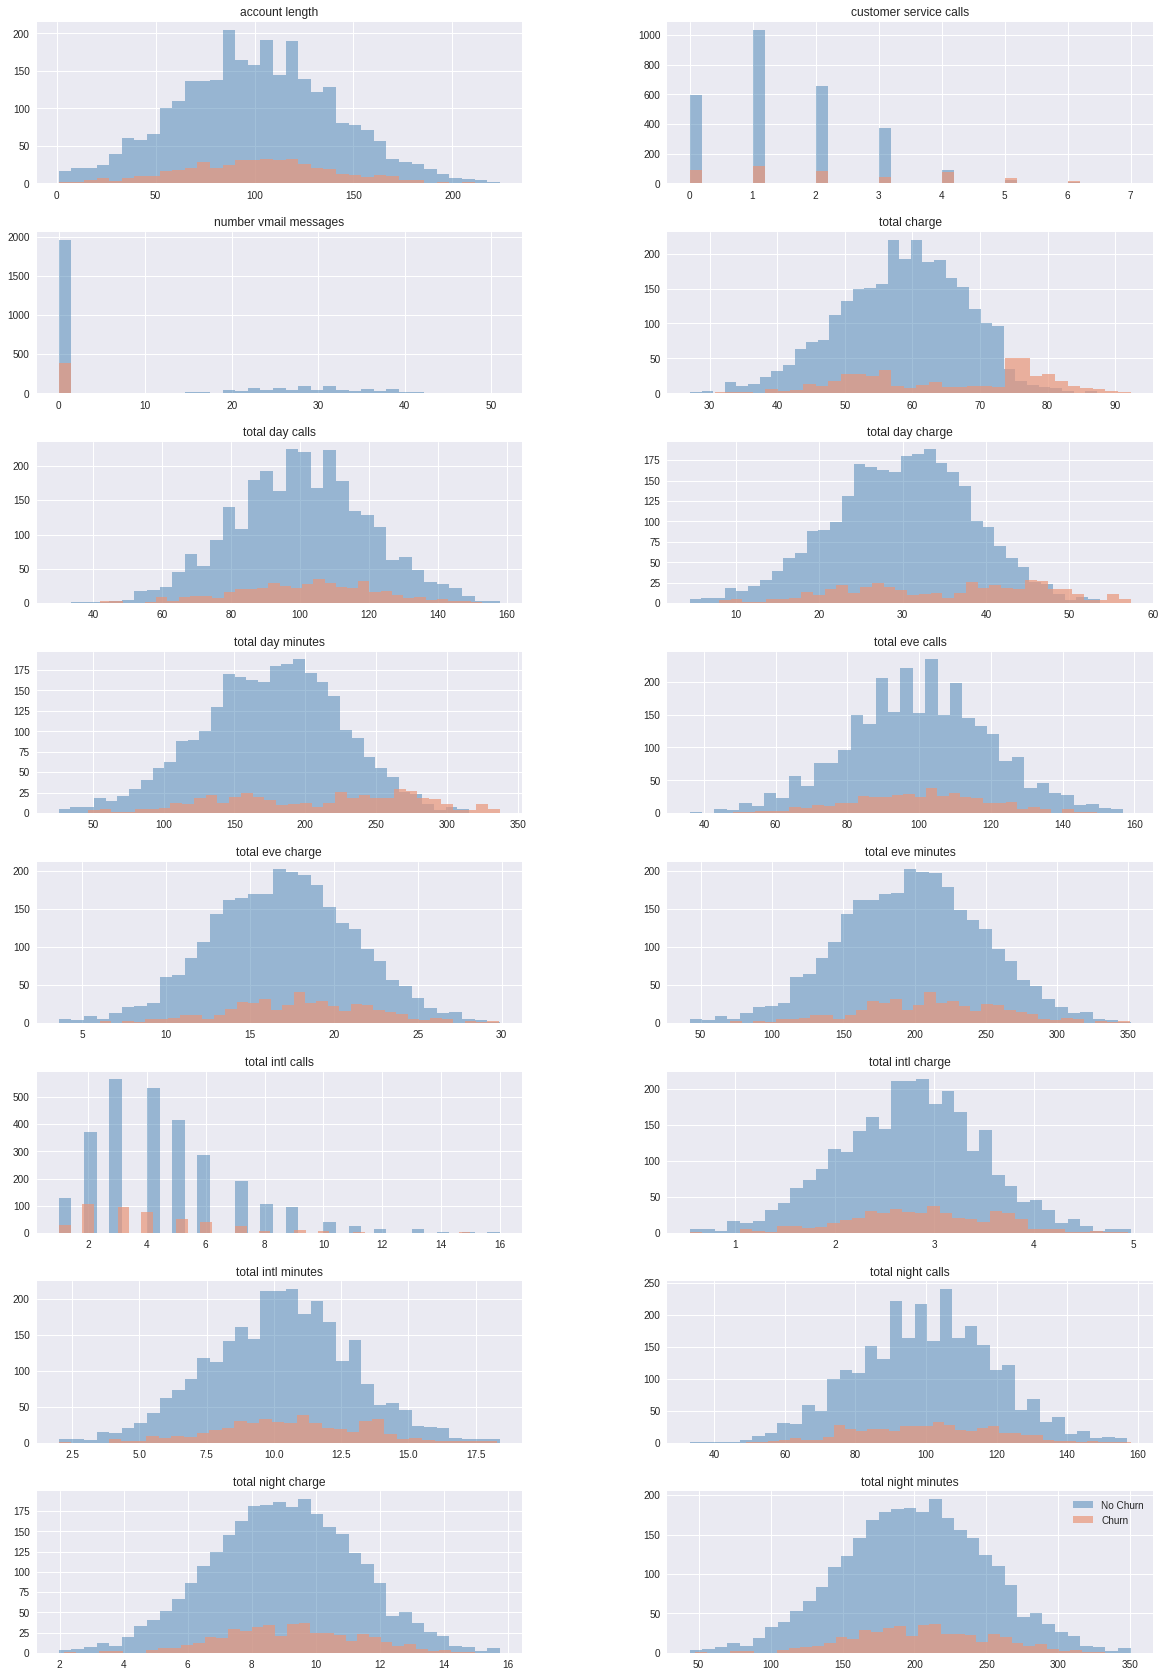

In [ ]:
fig, ax = plt.subplots(8, 2, figsize=(20, 30))
df[df.churn == False][con_feats].hist(bins=35, color="steelblue", alpha=0.5, ax=ax)
df[df.churn == True][con_feats].hist(bins=35, color="darksalmon", alpha=0.7, ax=ax)
plt.legend(['No Churn', 'Churn'])

#### General comments on the visualization 
* 'customer service calls' is positively skewed. 
* In the'total intl calls' histogram, both churned and non-churned users are having a similar number of international calls
* In the histograms for 'total day minutes', 'total_day_charge', and 'total charge', the customer with higher values in these features are more likely to churn 
* In the 'total intl minutes' histogram, churned customers tend to have longer international calls (longer in minutes) than non-churned customers
* In the 'number vmail messages' histogram, the users who did not churn tends to have more voice mail messages

### Scale continuous data with StandardScaler

In [ ]:
ss = StandardScaler()
scaled = ss.fit_transform(df[con_feats])
scaled = pd.DataFrame(scaled, columns=con_feats)

In [ ]:
# Drop the original values and merge the scaled values for continuous columns
df1 = df.drop(columns=con_feats, axis = 1)
df1 = df1.merge(scaled, left_index=True, right_index=True, how = "left")
df1.head()

,state,international plan,voice mail plan,churn,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,total charge
0,16,0,1,False,0.684493,1.231227,1.583033,0.484641,1.583309,-0.070841,-0.056774,-0.070657,0.887602,-0.463600,0.886873,-0.109483,-0.624440,-0.110199,-0.427540,1.553196
1,35,0,1,False,0.154991,1.304175,-0.347270,1.140403,-0.347550,-0.108651,0.146279,-0.108116,1.082106,0.152308,1.082933,1.272021,-0.624440,1.272751,-0.427540,-0.027025
2,31,0,0,False,0.911422,-0.592465,1.178322,0.686414,1.178487,-1.587209,0.501621,-1.587729,-0.758668,0.203634,-0.757354,0.711952,0.217444,0.705742,-1.199289,0.268298
3,35,1,0,False,-0.424939,-0.592465,2.222738,-1.482643,2.222906,-2.767269,-0.615168,-2.767673,-0.070884,-0.566251,-0.071145,-1.378973,1.059328,-1.382513,0.344210,0.704989
4,36,1,0,False,-0.651869,-0.592465,-0.252154,0.635971,-0.252104,-1.047923,1.110778,-1.046921,-0.271405,1.076169,-0.271661,-0.072145,-0.624440,-0.068711,1.115959,-0.719340


# Multicollinearity Check

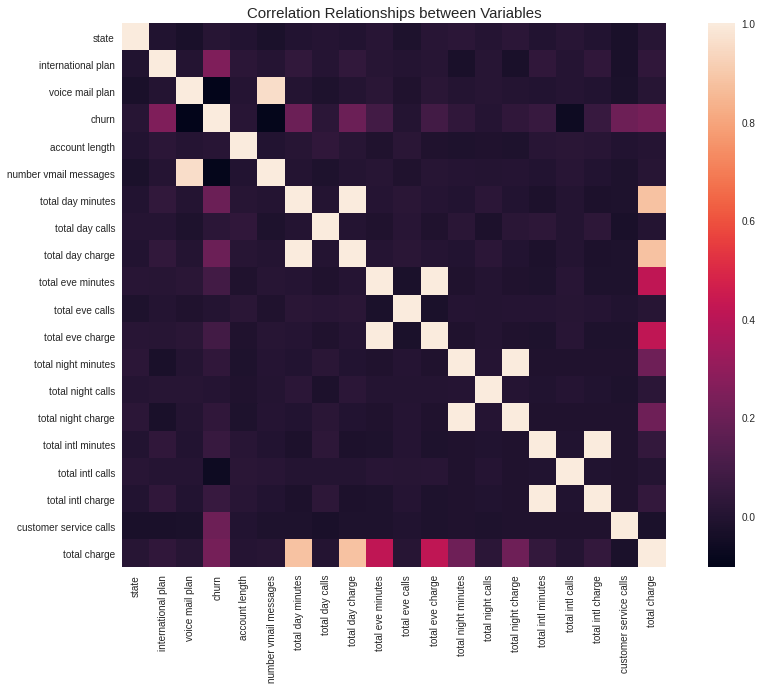

In [ ]:
corr = df1.corr()
f, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr, vmax=1., square=True)
plt.title('Correlation Relationships between Variables', fontsize=15)
plt.show()

#### General comments on the correlation between features and target
* High correlation between 'voice mail plan' and 'number vmail messages' --> makes sense because customers with a voice mail plan send more voice mail messages
* Greatly high correlation between 'total day minutes' and 'total day charge'. I also found the same patterns for other pairs: 'total eve minutes' and 'total eve charge', 'total night minutes' and 'total night charge', and 'total intl minutes' and 'total intl charge' --> the telecom company seems to charge customers by minutes of calls
* There are also a slightly lower correlations between 'total charge' with 'total day minutes', and with 'total day charge'

# Feature Selection by Statsmodel's Ordinary Least Squares (OLS)

In [ ]:
# Define features X and target y
y = df1['churn']
X = df1.drop('churn', axis=1)

# Define the intercept
X = sm.add_constant(X)

# Fit a model
model = sm.OLS(y, X)
result = model.fit()

# Summarize results
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  churn   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     38.59
Date:                Sat, 11 Jul 2020   Prob (F-statistic):          2.56e-122
Time:                        02:51:05   Log-Likelihood:                -895.67
No. Observations:                3260   AIC:                             1829.
Df Residuals:                    3241   BIC:                             1945.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1460      0.017      8.739      0.000       0.113       0.179
state                      0.0003      0.000      0.780      0.436      -0.000       0.001
international plan         0.2987      0.019     15.702      0.000       0.261       0.336
voice mail plan           -0.1392      0.043     -3.216      0.001      -0.224      -0.054
account length             0.0036      0.006      0.636      0.525      -0.007       0.015
number vmail messages      0.0284      0.019      1.467      0.142      -0.010       0.066
total day minutes          4.6697     17.843      0.262      0.794     -30.316      39.655
total day calls            0.0079      0.006      1.406      0.160      -0.003       0.019
total day charge          -1.9825     11.005     -0.180      0.857     -23.560      19.595
total eve minutes          5.8499      8.299      0.705      0.481     -10.423      22.122
total eve calls           -0.0002      0.006     -0.044      0.965      -0.011       0.011
total eve charge          -4.5898      8.267     -0.555      0.579     -20.799      11.620
total night minutes       -2.0651      4.414     -0.468      0.640     -10.719       6.589
total night calls          0.0021      0.006      0.370      0.711      -0.009       0.013
total night charge         2.7261      4.615      0.591      0.555      -6.322      11.774
total intl minutes        -1.0345      1.407     -0.735      0.462      -3.794       1.725
total intl calls          -0.0222      0.006     -3.967      0.000      -0.033      -0.011
total intl charge          1.2613      1.510      0.835      0.404      -1.700       4.223
customer service calls     0.0755      0.006     13.472      0.000       0.065       0.087
total charge              -2.9673      8.074     -0.368      0.713     -18.797      12.863
==============================================================================
Omnibus:                      807.338   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1589.775
Skew:                           1.506   Prob(JB):                         0.00
Kurtosis:                       4.623   Cond. No.                     5.41e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  1e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Top features by OLS by on p-values (<0.05):** international plan, total intl calls, customer service calls, and voice mail plan 

# Feature Selection by LassoCV

Using LassoCV to find the optimal alpha value for L1 regularization

In [ ]:
# Scale the features X on both the train and test sets
ss = StandardScaler()
ss.fit(X.values)
X_scaled = ss.transform(X.values)
print('X_scaled', X_scaled.shape)
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-3, 3, 200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)
# Print out the best alpha value found
print('LASSO best alpha: ', lasso_model.alpha_ )
# Display all coefficients in the model with optimal alpha
list(zip(X.columns, lasso_model.coef_))

X_scaled (3260, 20)
LASSO best alpha:  0.0032550885998350564


[('const', 0.0),
 ('state', 0.0011459079859754057),
 ('international plan', 0.08503870980482835),
 ('voice mail plan', -0.0320266823247972),
 ('account length', 0.0001486386768698084),
 ('number vmail messages', -0.0),
 ('total day minutes', 0.0),
 ('total day calls', 0.004882051614455233),
 ('total day charge', 0.0),
 ('total eve minutes', 0.0),
 ('total eve calls', -0.0),
 ('total eve charge', 0.0),
 ('total night minutes', 0.0),
 ('total night calls', 0.0),
 ('total night charge', 0.0),
 ('total intl minutes', 0.0),
 ('total intl calls', -0.018546600591777467),
 ('total intl charge', 0.010846472279220302),
 ('customer service calls', 0.07214773012743074),
 ('total charge', 0.07474330109831254)]

### Visualize the results

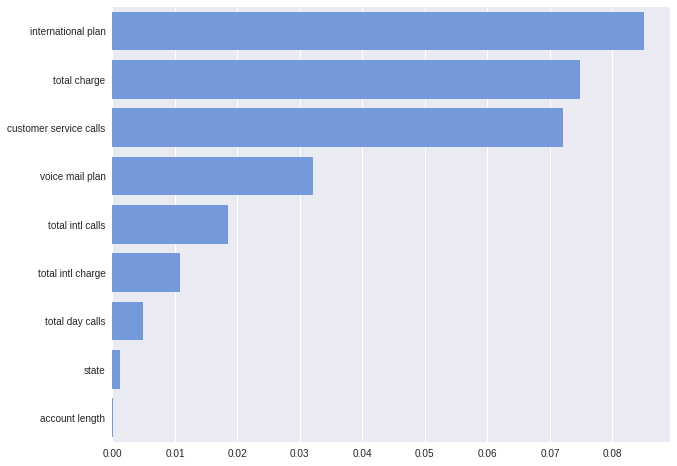

In [ ]:
lasso_feats = ['international plan', 'total charge', 'customer service calls', 'voice mail plan',
               'total intl calls', 'total intl charge', 'total day calls', 'state', 'account length']

lasso_coef = [0.0850387098, 0.0747433010, 0.0721477301, 0.0320266823, 0.0185466005, 
              0.0108464722, 0.0048820516, 0.0011459079, 0.0001486386]

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(y = lasso_feats, x = lasso_coef, ax=ax, color='cornflowerblue')

**Important features by LassoCV:** international plan, total charge, customer service calls, voice mail plan and total intl calls

# Build Models

### Function to plot Confusion Matrix

In [ ]:
# Add appropriate axis scales
# Get class labels to add to matrix
class_names = set(y) 

In [ ]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, cmap=cmap)
    
    # Add title and axis labels 
    plt.title('Confusion Matrix') 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')
    
    # Add appropriate axis scales
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Text formatting
    fmt = '.2f' if normalize else 'd'
    # Add labels to each cell
    thresh = cm.max() / 2.
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    # Add a legend
    plt.colorbar()
    plt.show() 

### GridSearchCV

Function for GridSearchCV

In [ ]:
def gridsearch_cv(clf, params, X_train, y_train, cv):
    pipeline = Pipeline([('clf', clf)]) 
    gs = GridSearchCV(pipeline, params, cv=kf, n_jobs=-1, scoring='f1', return_train_score=True)
    gs.fit(X_train, y_train)
    return gs

Define the parameter grid for each classifier 

In [ ]:
logistic_regression_params = {'clf__solver': ['liblinear'], 
                              'clf__C': [0.1, 1, 10],
                              'clf__penalty': ['l2', 'l1']}

random_forest_params = {'clf__max_depth': [25, 50, 75],
                        # just sqrt is used because values of log2 and sqrt are very similar for our number of features (10-19)
                        'clf__max_features': ['sqrt'],
                        'clf__criterion': ['gini', 'entropy'],
                        'clf__n_estimators': [100, 300, 500, 1000]}

knn_params = {'clf__n_neighbors': [5, 15, 25, 35, 45, 55, 65],
              'clf__weights': ['uniform', 'distance'],
              'clf__p': [1, 2, 10]}

decision_tree_params = {'clf__max_depth': [25, 50, 75],
                        'clf__max_features': ['sqrt'],
                        'clf__criterion': ['gini', 'entropy'],
                        'clf__min_samples_split': [6, 10, 14],}

xgb_params = {'clf__learning_rate': [0.1],
              'clf__max_depth': [1, 3, 6],
              'clf__n_estimators' : [30, 100, 250],
              'clf__min_child_weight': [4, 6, 10],
              'clf__subsample': [0.7]}

In [ ]:
kf = StratifiedKFold(n_splits=5, random_state=42)

### Train Test Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1) LogisticRegression

In [ ]:
logit = LogisticRegression(C=1.0)
gs_logit = gridsearch_cv(logit, logistic_regression_params, X_train, y_train, kf)
predictions = gs_logit.predict(X_test)

In [ ]:
print('Accuracy Score', accuracy_score(y_test, predictions))
print('Recall Score', recall_score(y_test, predictions))
print('F1 Score', f1_score(y_test, predictions))
print('AUC', roc_auc_score(y_test, predictions))

Accuracy Score 0.8634969325153374
Recall Score 0.24742268041237114
F1 Score 0.35036496350364965
AUC 0.6092969257917711


In [ ]:
logit_matrix = confusion_matrix(y_test, predictions)
print('Logistic Regression Confusion Matrix: \n', logit_matrix)

Logistic Regression Confusion Matrix: 
 [[539  16]
 [ 73  24]]


Normalized confusion matrix


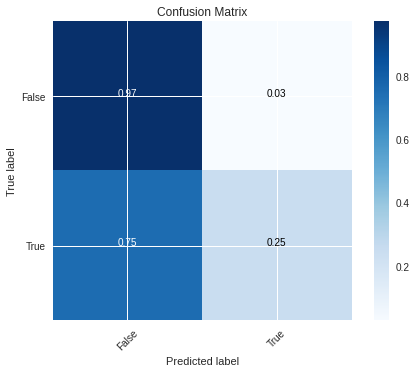

In [ ]:
plot_confusion_matrix(logit_matrix, classes=class_names, normalize=True)

### 2) Random Forest

In [ ]:
rfc = RandomForestClassifier(random_state=18)
gs_rfc = gridsearch_cv(rfc, random_forest_params, X_train, y_train, kf)
predictions2 = gs_rfc.predict(X_test)

In [ ]:
print('Accuracy Score', accuracy_score(y_test, predictions2))
print('Recall Score', recall_score(y_test, predictions2))
print('F1 Score', f1_score(y_test, predictions2))
print('AUC', roc_auc_score(y_test, predictions2))

Accuracy Score 0.9800613496932515
Recall Score 0.865979381443299
F1 Score 0.9281767955801106
AUC 0.9329896907216495


In [ ]:
rfc_matrix = confusion_matrix(y_test, predictions2)
print('Random Forest Classifier Confusion Matrix: \n', rfc_matrix)

Random Forest Classifier Confusion Matrix: 
 [[555   0]
 [ 13  84]]


Normalized confusion matrix


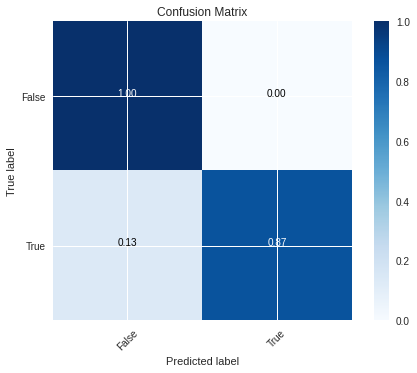

In [ ]:
plot_confusion_matrix(rfc_matrix, classes=class_names, normalize=True)

### 3) K-Nearest Neighbor

In [ ]:
knn = KNeighborsClassifier()
gs_knn = gridsearch_cv(knn, knn_params, X_train, y_train, kf)
predictions3 = gs_knn.predict(X_test)

In [ ]:
print('Accuracy Score', accuracy_score(y_test, predictions3))
print('Recall Score', recall_score(y_test, predictions3))
print('F1 Score', f1_score(y_test, predictions3))
print('AUC', roc_auc_score(y_test, predictions3))

Accuracy Score 0.8742331288343558
Recall Score 0.18556701030927836
F1 Score 0.3050847457627119
AUC 0.5900808024519365


In [ ]:
knn_matrix = confusion_matrix(y_test, predictions3)
print('K-Nearest Neighbor Confusion Matrix: \n', knn_matrix)

K-Nearest Neighbor Confusion Matrix: 
 [[552   3]
 [ 79  18]]


Normalized confusion matrix


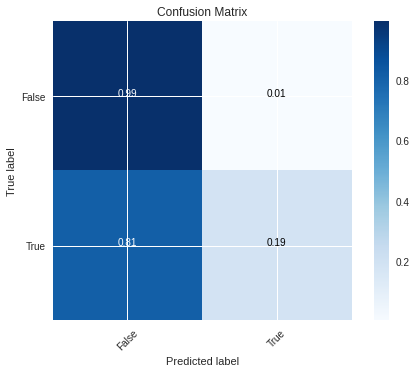

In [ ]:
plot_confusion_matrix(knn_matrix, classes=class_names, normalize=True)

### 4) Decision Tree

In [ ]:
dtc = DecisionTreeClassifier()
gs_dtc = gridsearch_cv(dtc, decision_tree_params, X_train, y_train, kf)
predictions4 = gs_dtc.predict(X_test)

In [ ]:
print('Accuracy Score', accuracy_score(y_test, predictions4))
print('Recall Score', recall_score(y_test, predictions4))
print('F1 Score', f1_score(y_test, predictions4))
print('AUC', roc_auc_score(y_test, predictions4))

Accuracy Score 0.9095092024539877
Recall Score 0.6391752577319587
F1 Score 0.6775956284153005
AUC 0.7979660072443577


In [ ]:
dtc_matrix = confusion_matrix(y_test, predictions4)
print('Decistion Tree Confusion Matrix: \n', dtc_matrix)

Decistion Tree Confusion Matrix: 
 [[531  24]
 [ 35  62]]


Normalized confusion matrix


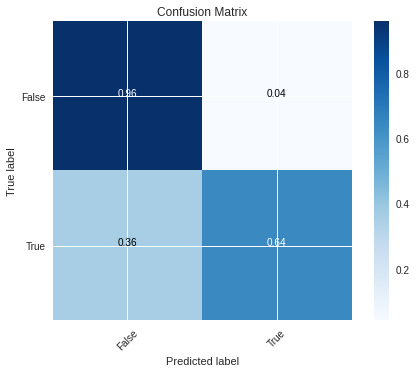

In [ ]:
plot_confusion_matrix(dtc_matrix, classes=class_names, normalize=True)

### 5) XGBoost 

In [ ]:
xgb = xgb.XGBClassifier()
gs_xgb = gridsearch_cv(xgb, xgb_params, X_train, y_train, kf)
predictions5 = gs_xgb.predict(X_test)

In [ ]:
print('Accuracy Score', accuracy_score(y_test, predictions5))
print('Recall Score', recall_score(y_test, predictions5))
print('F1 Score', f1_score(y_test, predictions5))
print('AUC', roc_auc_score(y_test, predictions5))

Accuracy Score 0.9815950920245399
Recall Score 0.8762886597938144
F1 Score 0.9340659340659341
AUC 0.9381443298969072


In [ ]:
xgb_matrix = confusion_matrix(y_test, predictions5)
print('XGBoost Confusion Matrix: \n', xgb_matrix)

XGBoost Confusion Matrix: 
 [[555   0]
 [ 12  85]]


Normalized confusion matrix


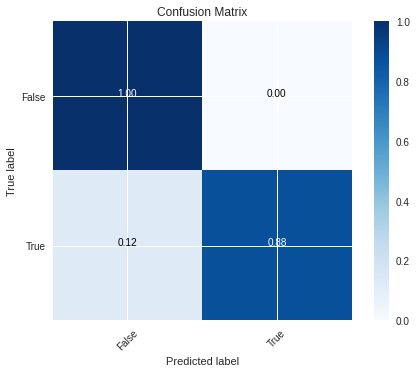

In [ ]:
plot_confusion_matrix(xgb_matrix, classes=class_names, normalize=True)

### Plot Receiver Operating Characteristic (ROC) Curve

The ROC curve (Receiver Operating Characteristics curve) is the display of sensitivity and specificity for different cut-off values for probability (If the probability of positive response is above the cut-off, we predict a positive outcome, if not we are predicting a negative one). Each cut-off value defines one point on ROC curve, ranging cut-off from 0 to 1 will draw the whole ROC curve.

In short, ROC curve tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, the higher the AUC, better the model is at distinguishing between churned customers and non-churned customers.

ROC Curve is generated by plotting the True Positive rate (y-axis) against the False Positive rate (x-axis).

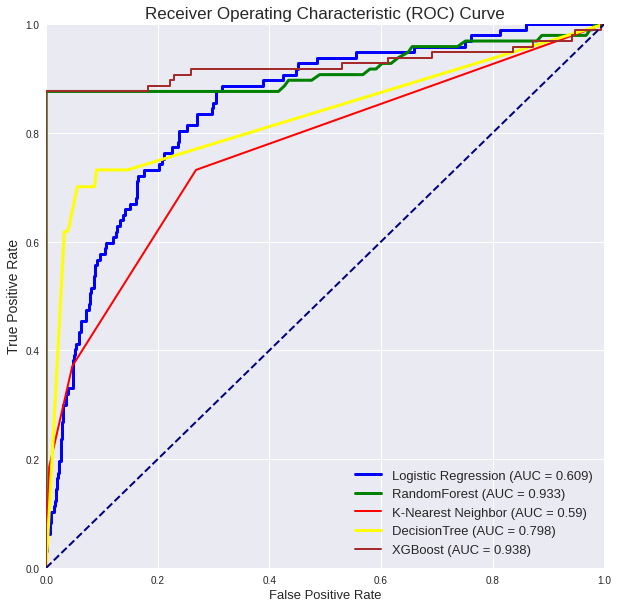

In [ ]:
plt.figure(figsize=(10,10))

y_pred = gs_logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='blue',
         lw=3, label='Logistic Regression (AUC = {})'.format(round(roc_auc_score(y_test, predictions), 3)))

y_pred = gs_rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='green',
         lw=3, label='RandomForest (AUC = {})'.format(round(roc_auc_score(y_test, predictions2), 3)))

y_pred = gs_knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red',
         lw=2, label='K-Nearest Neighbor (AUC = {})'.format(round(roc_auc_score(y_test, predictions3), 3)))

y_pred = gs_dtc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='yellow',
         lw=3, label='DecisionTree (AUC = {})'.format(round(roc_auc_score(y_test, predictions4), 3)))

y_pred = gs_xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='brown',
         lw=2, label='XGBoost (AUC = {})'.format(round(roc_auc_score(y_test, predictions5), 3)))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

**Comment**: XGBoost has the highest AUC value, followed by RandomForest, DecisionTree, LogisticRegression. 

K-Nearest Neighbor has he lowest AUC value.

# Calculate metrics on test sets of each classifier

* Accuracy: How often is the classifier correct?

  Can be misleading with unbalanced datasets
* Precision: When it predicts yes, how often is it correct?

 Can be misleading if the model is very conservative about which cases they predict as true
* Recall: When it is actually yes, how often does it predict yes?

 Can get a 100% recall score by simply assuming every case is true, which would not necessarily be a better model
* F1: The harmonic average of precision and recall. 
 
 F1 cannot be high without both precision and recall being high. Therefore, in this case, F1 score is a great metric to choose which model is the best along with AUC.

In [ ]:
classifiers = [gs_logit, gs_rfc, gs_knn, gs_dtc, gs_xgb]
classifier_names = ['Logistic Regression', 'Random Forest', 'KNN', 'Decision Tree', 'XGBoost']
auc_scores = [0.60929692, 0.93298969, 0.59008080, 0.85491780, 0.98159509]

accs = []
recalls = []
precision = []
results_table = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1", "auc"])

for (i, clf), name, auc in zip(enumerate(classifiers), classifier_names, auc_scores):
    y_pred = clf.predict(X_test)
    row = []
    row.append(accuracy_score(y_test, y_pred))
    row.append(precision_score(y_test, y_pred))
    row.append(recall_score(y_test, y_pred))
    row.append(f1_score(y_test, y_pred))
    row.append(auc)
    row = ["%.3f" % r for r in row]
    results_table.loc[name] = row

print(results_table)

                    accuracy precision recall     f1    auc
Logistic Regression    0.863     0.600  0.247  0.350  0.609
Random Forest          0.980     1.000  0.866  0.928  0.933
KNN                    0.874     0.857  0.186  0.305  0.590
Decision Tree          0.910     0.721  0.639  0.678  0.855
XGBoost                0.982     1.000  0.876  0.934  0.982


**Comment**: 
* XGBoost has the highest AUC value and also the highest F1 score.
* RandomForest has the second highest AUC value and F1 score. However, it took a longer time to run. It is not a good model as it takes more time and memory storage.
* DecisionTree comes in the third place and Logistic Regression comes in the forth place.
* K-Nearest Neighbor has the lowest AUC value and also the lowest F1 score. 

To sum, XGBoost is the model that has the best performance.

# The Final Model

Obtain the feature importance from the chosen classifier which is XGBoost Classifier

Text(0.5, 1.0, 'Top Features by XGBoost')

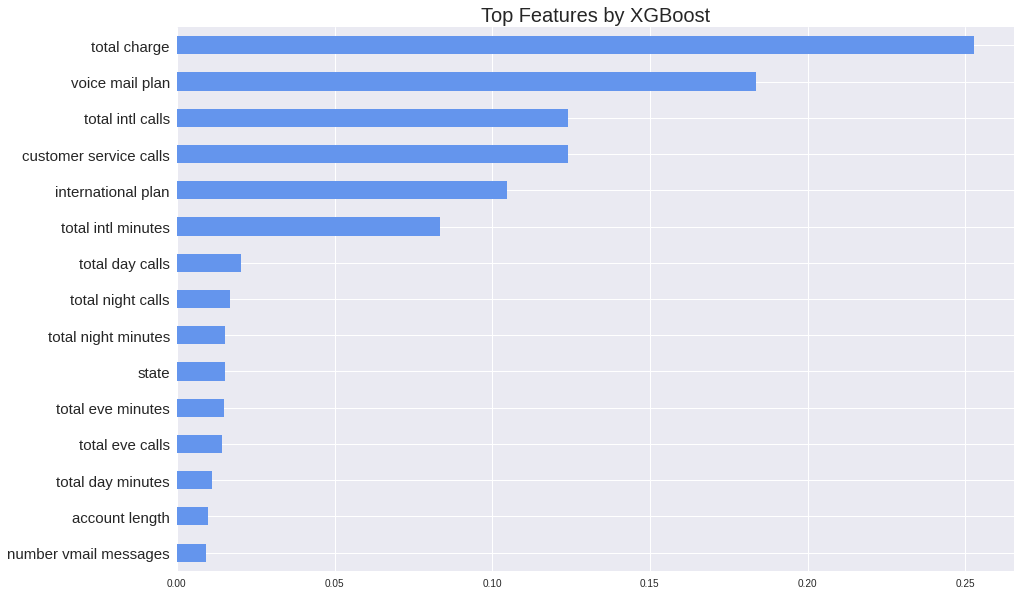

In [ ]:
# Fit the model
xgb_model = xgb.fit(X, y)

# Plot the top features based on its importance
(pd.Series(xgb_model.feature_importances_, index=X.columns)
   .nlargest(15)   # can adjust based on how many top features you want
   .plot(kind='barh', figsize=[15,10], color='cornflowerblue')
   .invert_yaxis()) # Ensures that the feature with the most importance is on top, in descending order

plt.yticks(size=15)
plt.title('Top Features by XGBoost', size=20)

# Conclusion

Several classifiers were used to train our models: Logistic Regression, Random Forest, K-Nearest Neighbor, Decision Tree, and XGBoost. Out of these 5 classifiers, XGBoost produced the best model with great performance in AUC and F1 score. According to XGBoost classifier, the five most important factors that have great impacts on churned customers are 'total charge', 'voicemail plan','total international calls', 'customer service calls', 'international plan'. Some of these features overlap with features that are initially selected from both OLS and LassoCV: 'international plan' and 'customer service calls'. 

To reduce the rate for churned customers, SyriaTel should focus on those factors above.